##Installing the Transformer Library by HuggingFace

In [1]:
!pip install -q -U watermark

In [2]:
!pip install -qq transformers

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.25.2
pandas      : 2.0.3
torch       : 2.3.1+cu121
transformers: 4.42.4



##Importing the required packages



In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

##Data Exploration

In [ ]:
from google.colab import files
uploaded = files.upload()

In [5]:
import pandas as pd
df = pd.read_csv('IMDB Dataset.csv')
df.shape

(50000, 2)

In [6]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Create the StratifiedShuffleSplit object
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Split the dataset
for train_index, test_index in stratified_split.split(df, df['sentiment']):
    df_sampled = df.iloc[test_index].reset_index(drop=True)

# Check the shape
print(df_sampled.shape)
print(df_sampled['sentiment'].value_counts())

(5000, 2)
sentiment
positive    2500
negative    2500
Name: count, dtype: int64


In [7]:
#df_sampled = df.sample(frac=0.01, random_state=42).reset_index(drop=True)
df=df_sampled
df.shape

(5000, 2)

In [8]:
df.head()

,review,sentiment
0,I'm not kidding about that summary and vote! T...,positive
1,"I kept waiting for the film to move me, inspir...",negative
2,This movie is a 90 minute Ramones concert with...,negative
3,Every scene was put together perfectly.This mo...,positive
4,"Uma and Travolta were very good together, but ...",negative


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


Great! we have no missing values in sentiment and review text. Let's check do we have class imbalance?

In [10]:
df.review[0]

'I\'m not kidding about that summary and vote! The video distributors have packaged this as just another typical \'80s werewolf movie, but it is in fact the greatest parody of the horror genre that you can imagine, having done for the horror movie what "Blazing Saddles" did for the western. I have seen plenty of comedies - good, bad, stupid, weird, etc. (usually walking away unimpressed), and I think that comedy must be the most difficult genre for filmmakers and actors to work in - it takes just the right kind of touch to make things successful, and part of that is having good ideas. "Full Moon High" is bulging with good ideas - so many, in fact, that it can easily put the Zucker/Abrams team of "Airplane" and "Naked Gun" to shame. One of the best of these is the very presence of Ed McMahon in a starring role as a John Birch-style right-wing crackpot. The jokes, non-sequiturs, wisecracks and word-play are literally non-stop and everything, including the kitchen sink, has been thrown in

In [11]:
def to_sentiment(rating):
  rating = str(rating)
  if rating == 'positive':
    return 0
  else:
    return 1

df['sentiment_score'] = df.sentiment.apply(to_sentiment)

Text(0.5, 0, 'Sentiment')

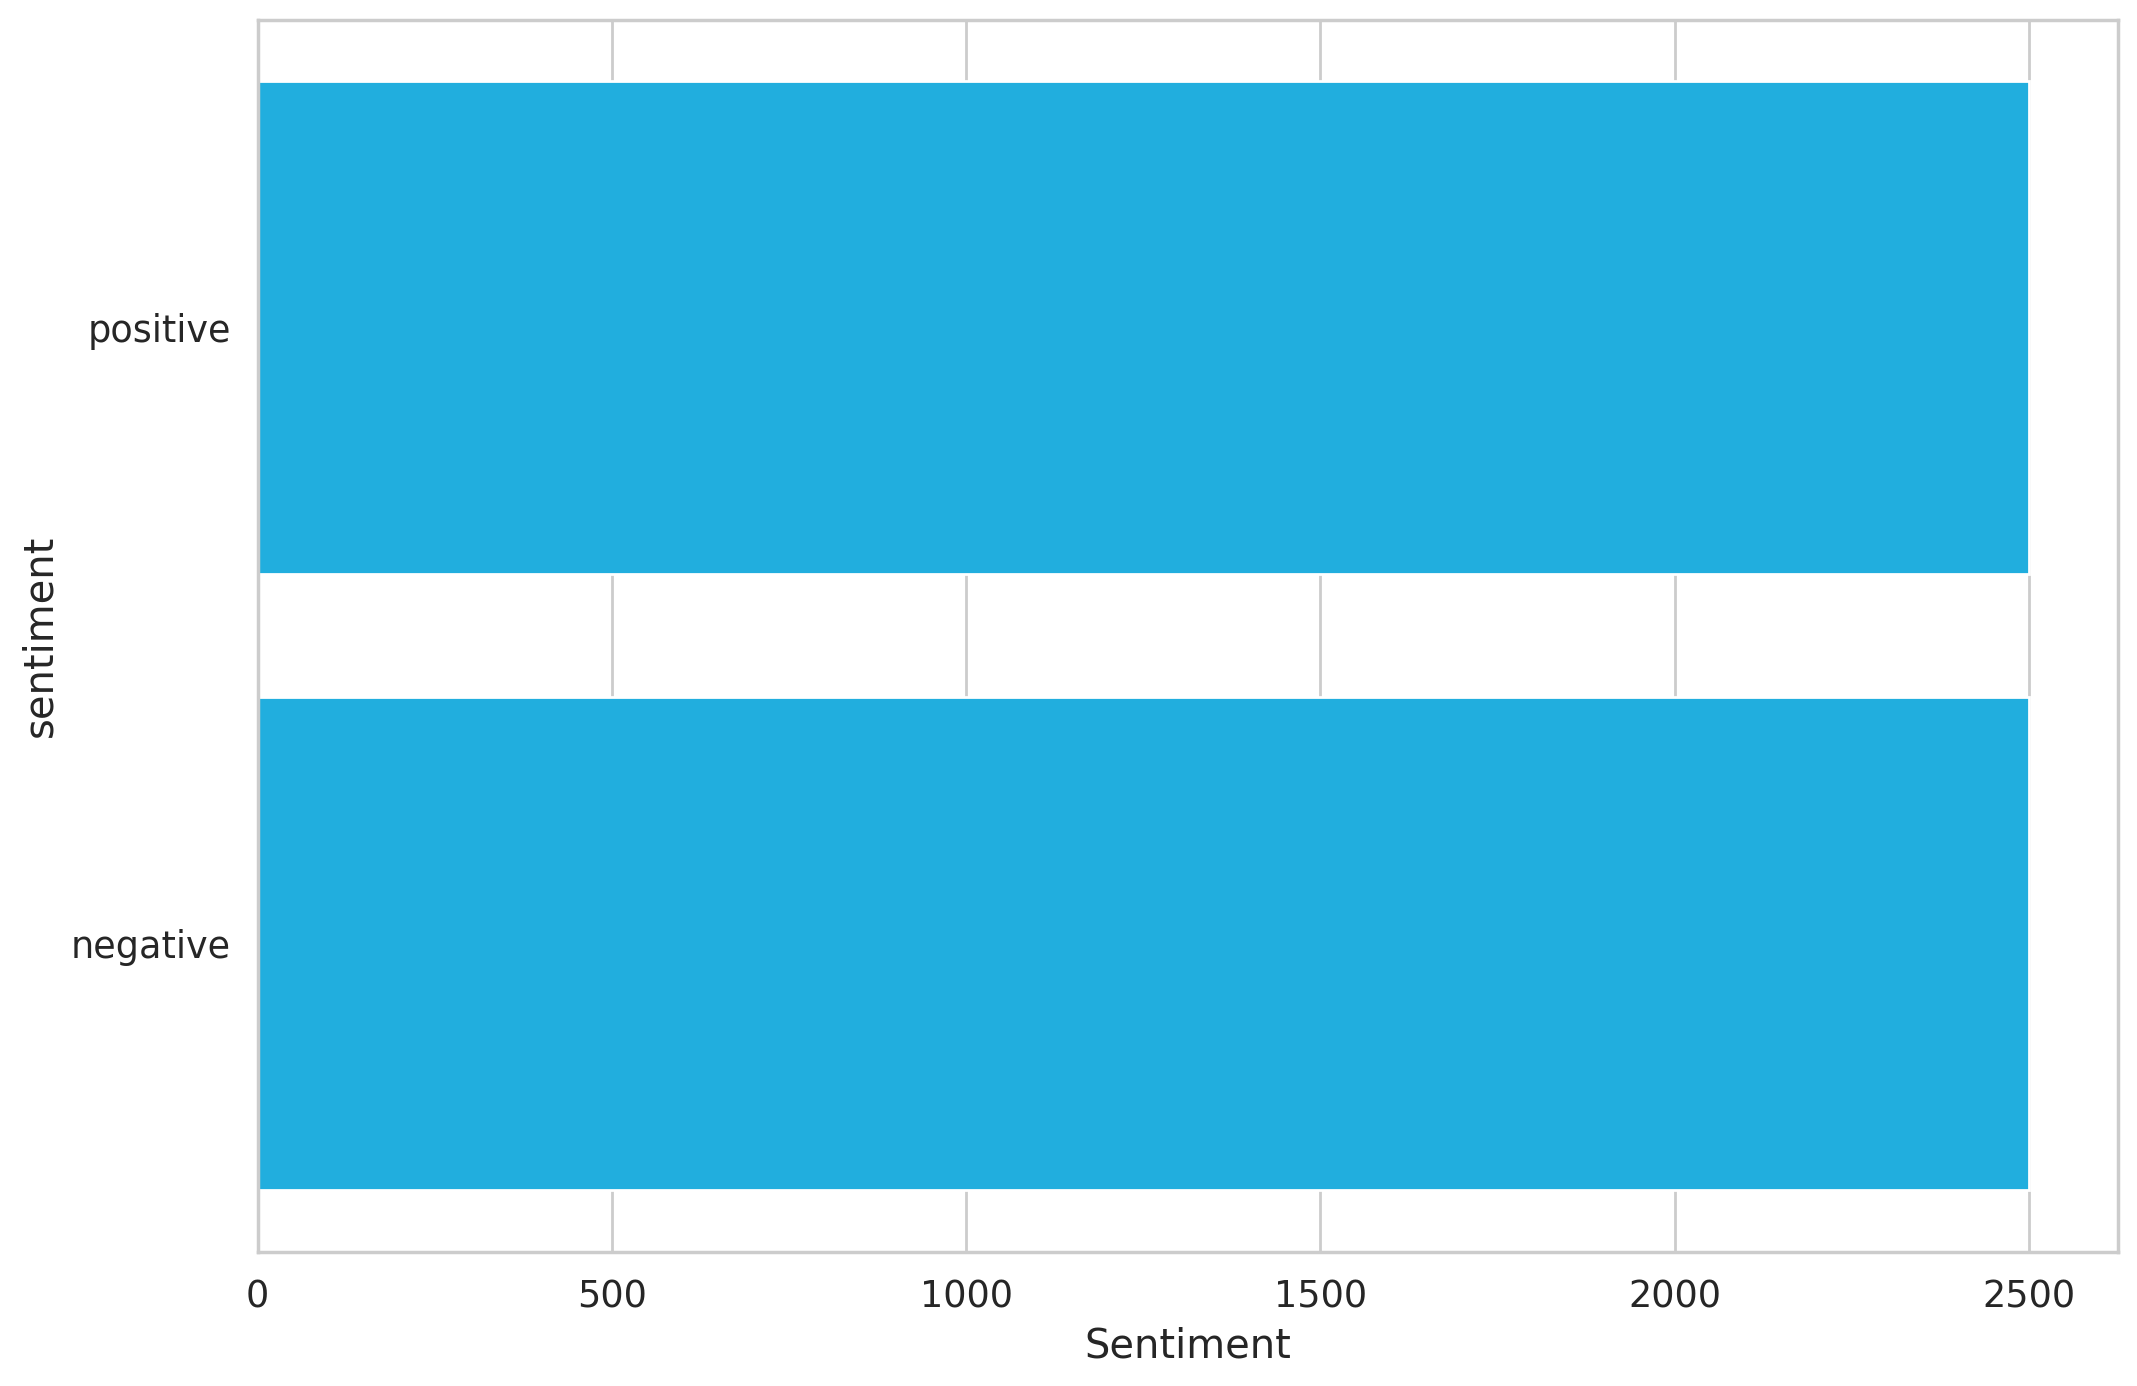

In [12]:
sns.countplot(df.sentiment)
plt.xlabel('Sentiment')

The count plot shows that the dataset is balanced.

##Data Preprocessing

The dataset needs to be pre processed before passing them to the model. So, we need to add special tokens to separate sentences and do classification. we will pass sequences of constant length (Padding) and have to create array of 0s and 1s which is nothing but attention mask.

The Transformers library provides a wide variety of Transformer models. It works with TensorFlow and PyTorch! we will be working with Pytorch and will be using BERT model for sentiment analysis. We are using cased version of BERT and tokenizer.

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Loading a pre-trained BertTokenizer

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

Encode_plus method of tokenizer adds special tokens like seperator[SEP], classifier [CLS], performs padding [PAD] so that BERT knows we are doing classification

In [16]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [17]:
token_lens = []

for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

<ipython-input-18-a09a938c7e92>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


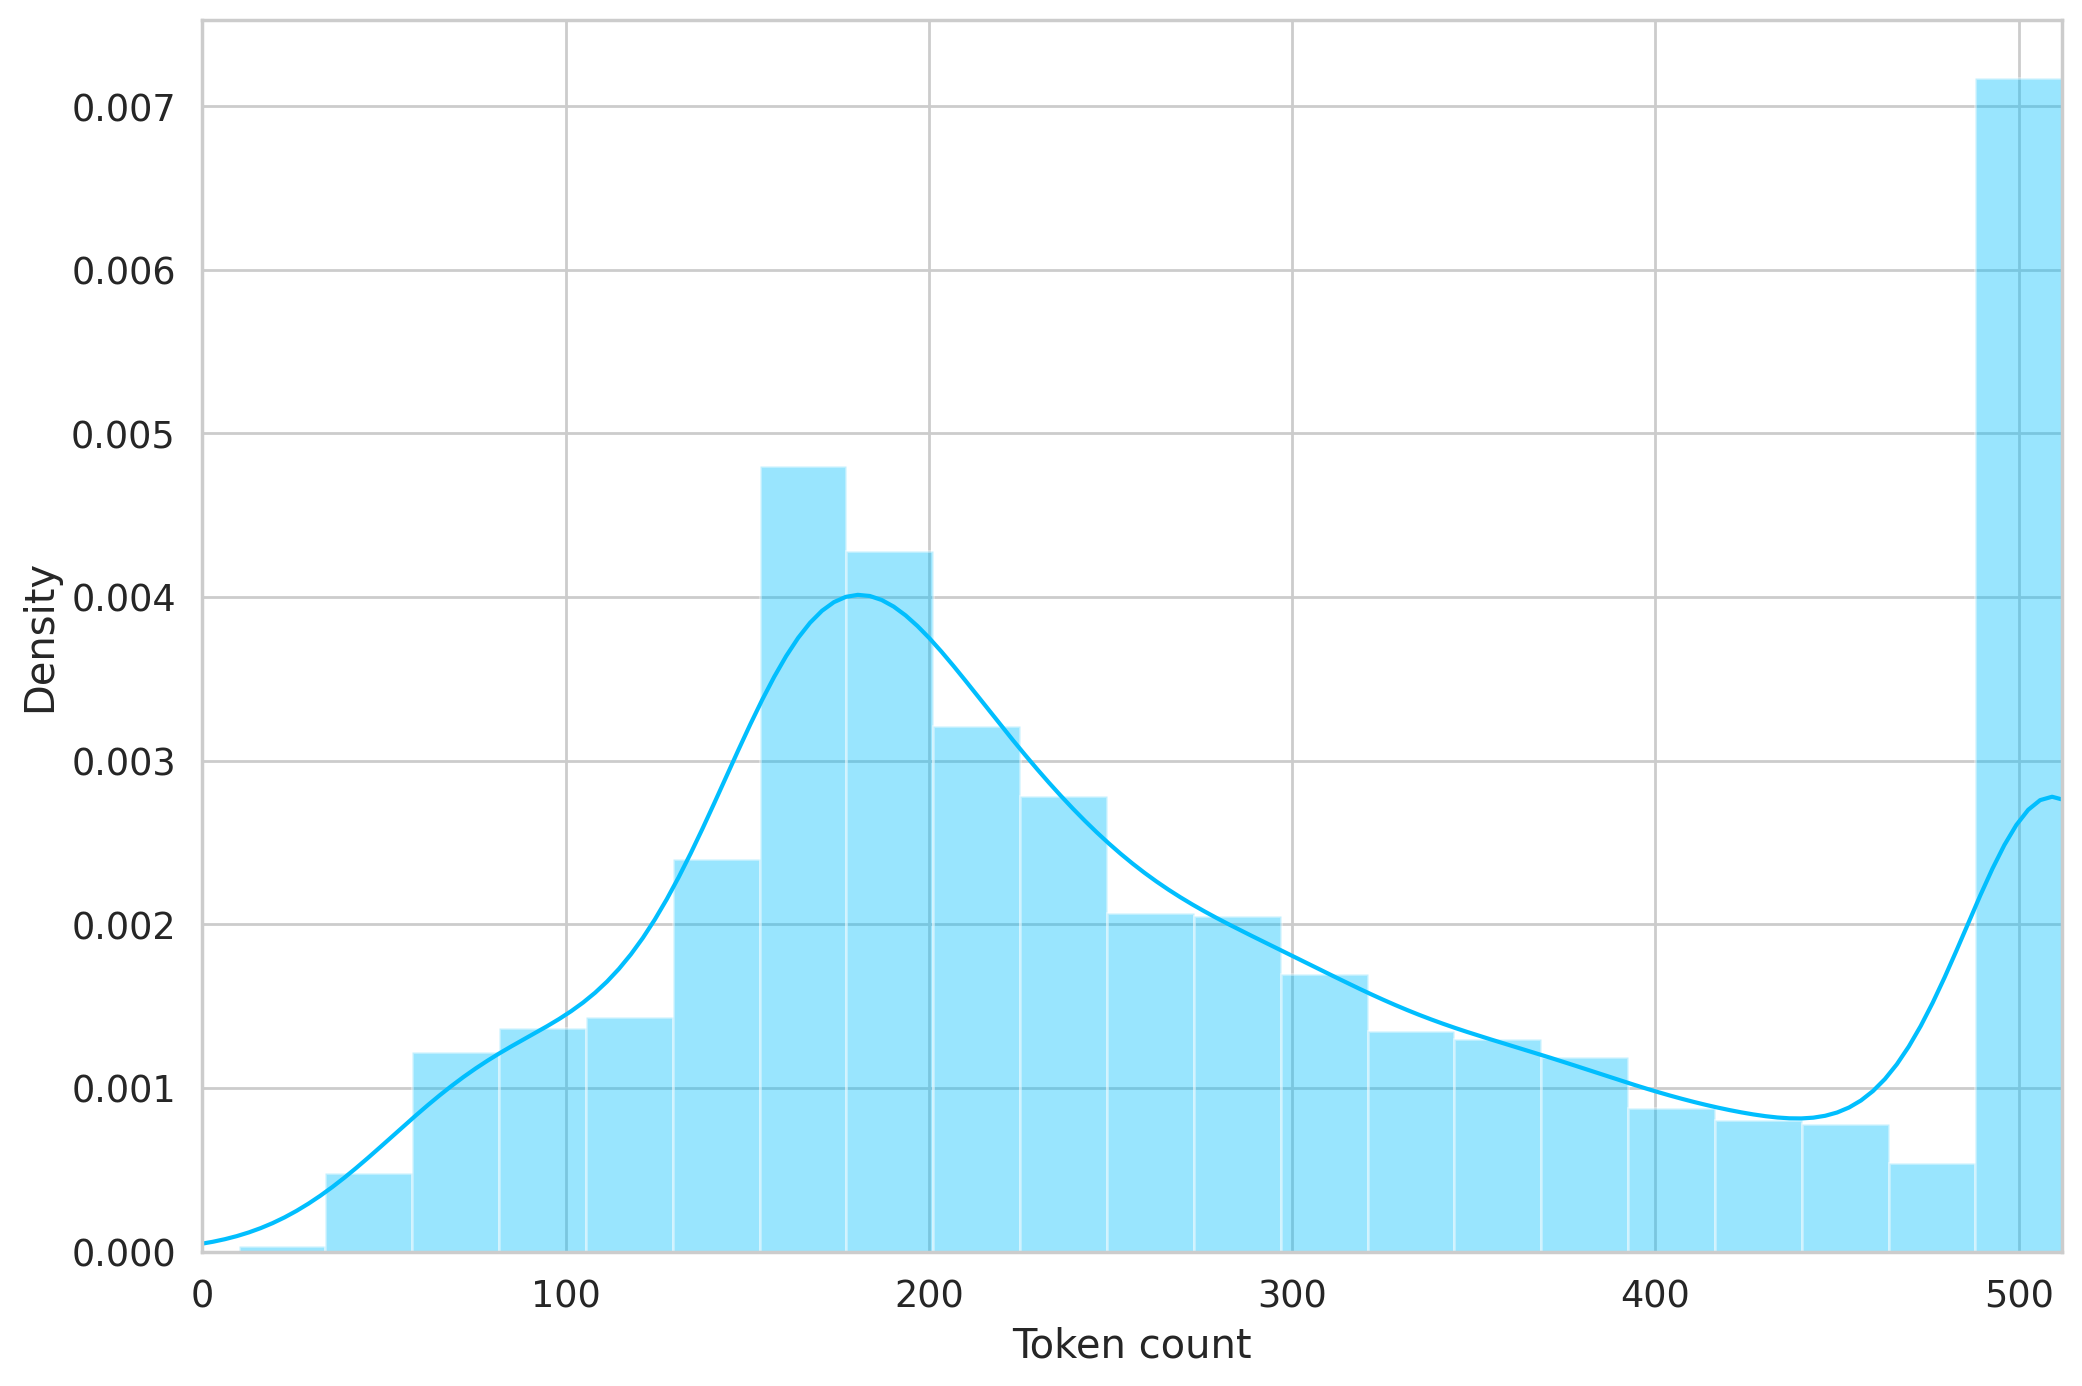

In [18]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

we are choosing maximum length of 400.

In [19]:
MAX_LEN = 400

Let's create pytorch dataset.

In [20]:
class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Let's split the dataset as 70% for training, and 15% each for validation and testing.

In [21]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [22]:
df_train.shape, df_val.shape, df_test.shape

((3500, 3), (750, 3), (750, 3))

Let's create data loaders.

In [23]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MovieReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment_score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [24]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [26]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 400])
torch.Size([16, 400])
torch.Size([16])


##Sentiment Classification with BERT and Hugging Face

We are using the BERT model and build the sentiment classifier on top of it. We then try to use the model on our sample text.

In [27]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [28]:
# Extract input_ids and attention_mask from the encoding
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

# Forward pass through the BERT model
outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output

torch.Size([1, 32])
torch.Size([1, 32])


In [29]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [30]:
bert_model.config.hidden_size

768

In [31]:
pooled_output.shape

torch.Size([1, 768])

Let's create the classifier that uses BERT model. We will use a dropout layer for regularization and a fully connected layer for output.

In [32]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [33]:
class_names = ['negative', 'positive']

In [34]:
len(class_names)

2

In [35]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

# Define the pre-trained model name
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Sample text for sentiment analysis
sample_text = "This is a sample sentence for sentiment analysis."

# Tokenize and encode the sample text
encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Ensure tensors are returned
)

# Prepare input data
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

# Instantiate the model
model = SentimentClassifier(n_classes=2)
model = model.to(device)

# Perform a forward pass and apply softmax
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    probs = F.softmax(outputs, dim=1)

print(probs)


tensor([[0.4249, 0.5751]], device='cuda:0')


In [36]:
import torch
torch.cuda.empty_cache()


In [37]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [38]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 400])
torch.Size([16, 400])


Let's apply softmax function to the outputs to get the predicted probabilities.

In [39]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.6253, 0.3747],
        [0.6611, 0.3389],
        [0.7263, 0.2737],
        [0.5595, 0.4405],
        [0.5076, 0.4924],
        [0.5193, 0.4807],
        [0.5600, 0.4400],
        [0.4920, 0.5080],
        [0.4695, 0.5305],
        [0.6249, 0.3751],
        [0.5417, 0.4583],
        [0.5626, 0.4374],
        [0.5026, 0.4974],
        [0.6507, 0.3493],
        [0.6882, 0.3118],
        [0.5480, 0.4520]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

##Training

For training we will use AdamW optimizer provided by hugging face.

In [40]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [41]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Evaluate the model on a given data loader.

In [42]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.44439086617400114 accuracy 0.7822857142857144


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.3343154897398137 accuracy 0.8453333333333333

Epoch 2/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.20539920820459112 accuracy 0.9325714285714286


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.40191971435350304 accuracy 0.8906666666666666

Epoch 3/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.07991180325205519 accuracy 0.9802857142857143


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.5668623252992241 accuracy 0.8906666666666666

Epoch 4/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.0313804652073756 accuracy 0.9920000000000001


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6692301090563675 accuracy 0.9013333333333333

Epoch 5/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.013605593887463262 accuracy 0.9971428571428572


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6934742529102802 accuracy 0.9026666666666666

Epoch 6/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.011650578629357191 accuracy 0.9974285714285716


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.7880645546275891 accuracy 0.8973333333333333

Epoch 7/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.0042000323057403395 accuracy 0.9991428571428572


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.7573750638037653 accuracy 0.9066666666666666

Epoch 8/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.0032062087851639233 accuracy 0.9991428571428572


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.8251604453975658 accuracy 0.9013333333333333

Epoch 9/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.00045597351218269955 accuracy 0.9997142857142858


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.7996399320090278 accuracy 0.9066666666666666

Epoch 10/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.00010370441121425315 accuracy 1.0


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.8033128675815145 accuracy 0.9066666666666666

CPU times: user 24min 30s, sys: 14min 45s, total: 39min 15s
Wall time: 41min 11s


Let's look at the training vs validation accuracy.

In [44]:
history

defaultdict(list,
            {'train_acc': [tensor(0.7823, device='cuda:0', dtype=torch.float64),
              tensor(0.9326, device='cuda:0', dtype=torch.float64),
              tensor(0.9803, device='cuda:0', dtype=torch.float64),
              tensor(0.9920, device='cuda:0', dtype=torch.float64),
              tensor(0.9971, device='cuda:0', dtype=torch.float64),
              tensor(0.9974, device='cuda:0', dtype=torch.float64),
              tensor(0.9991, device='cuda:0', dtype=torch.float64),
              tensor(0.9991, device='cuda:0', dtype=torch.float64),
              tensor(0.9997, device='cuda:0', dtype=torch.float64),
              tensor(1., device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.44439086617400114,
              0.20539920820459112,
              0.07991180325205519,
              0.0313804652073756,
              0.013605593887463262,
              0.011650578629357191,
              0.0042000323057403395,
              0.00320620878516

In [45]:
import torch
import pickle

# Load the best model state from the saved .bin file
model_state = torch.load('best_model_state.bin')

# Save the model state as a .pkl file
with open('nlp_bert.pkl', 'wb') as f:
    pickle.dump(model_state, f)

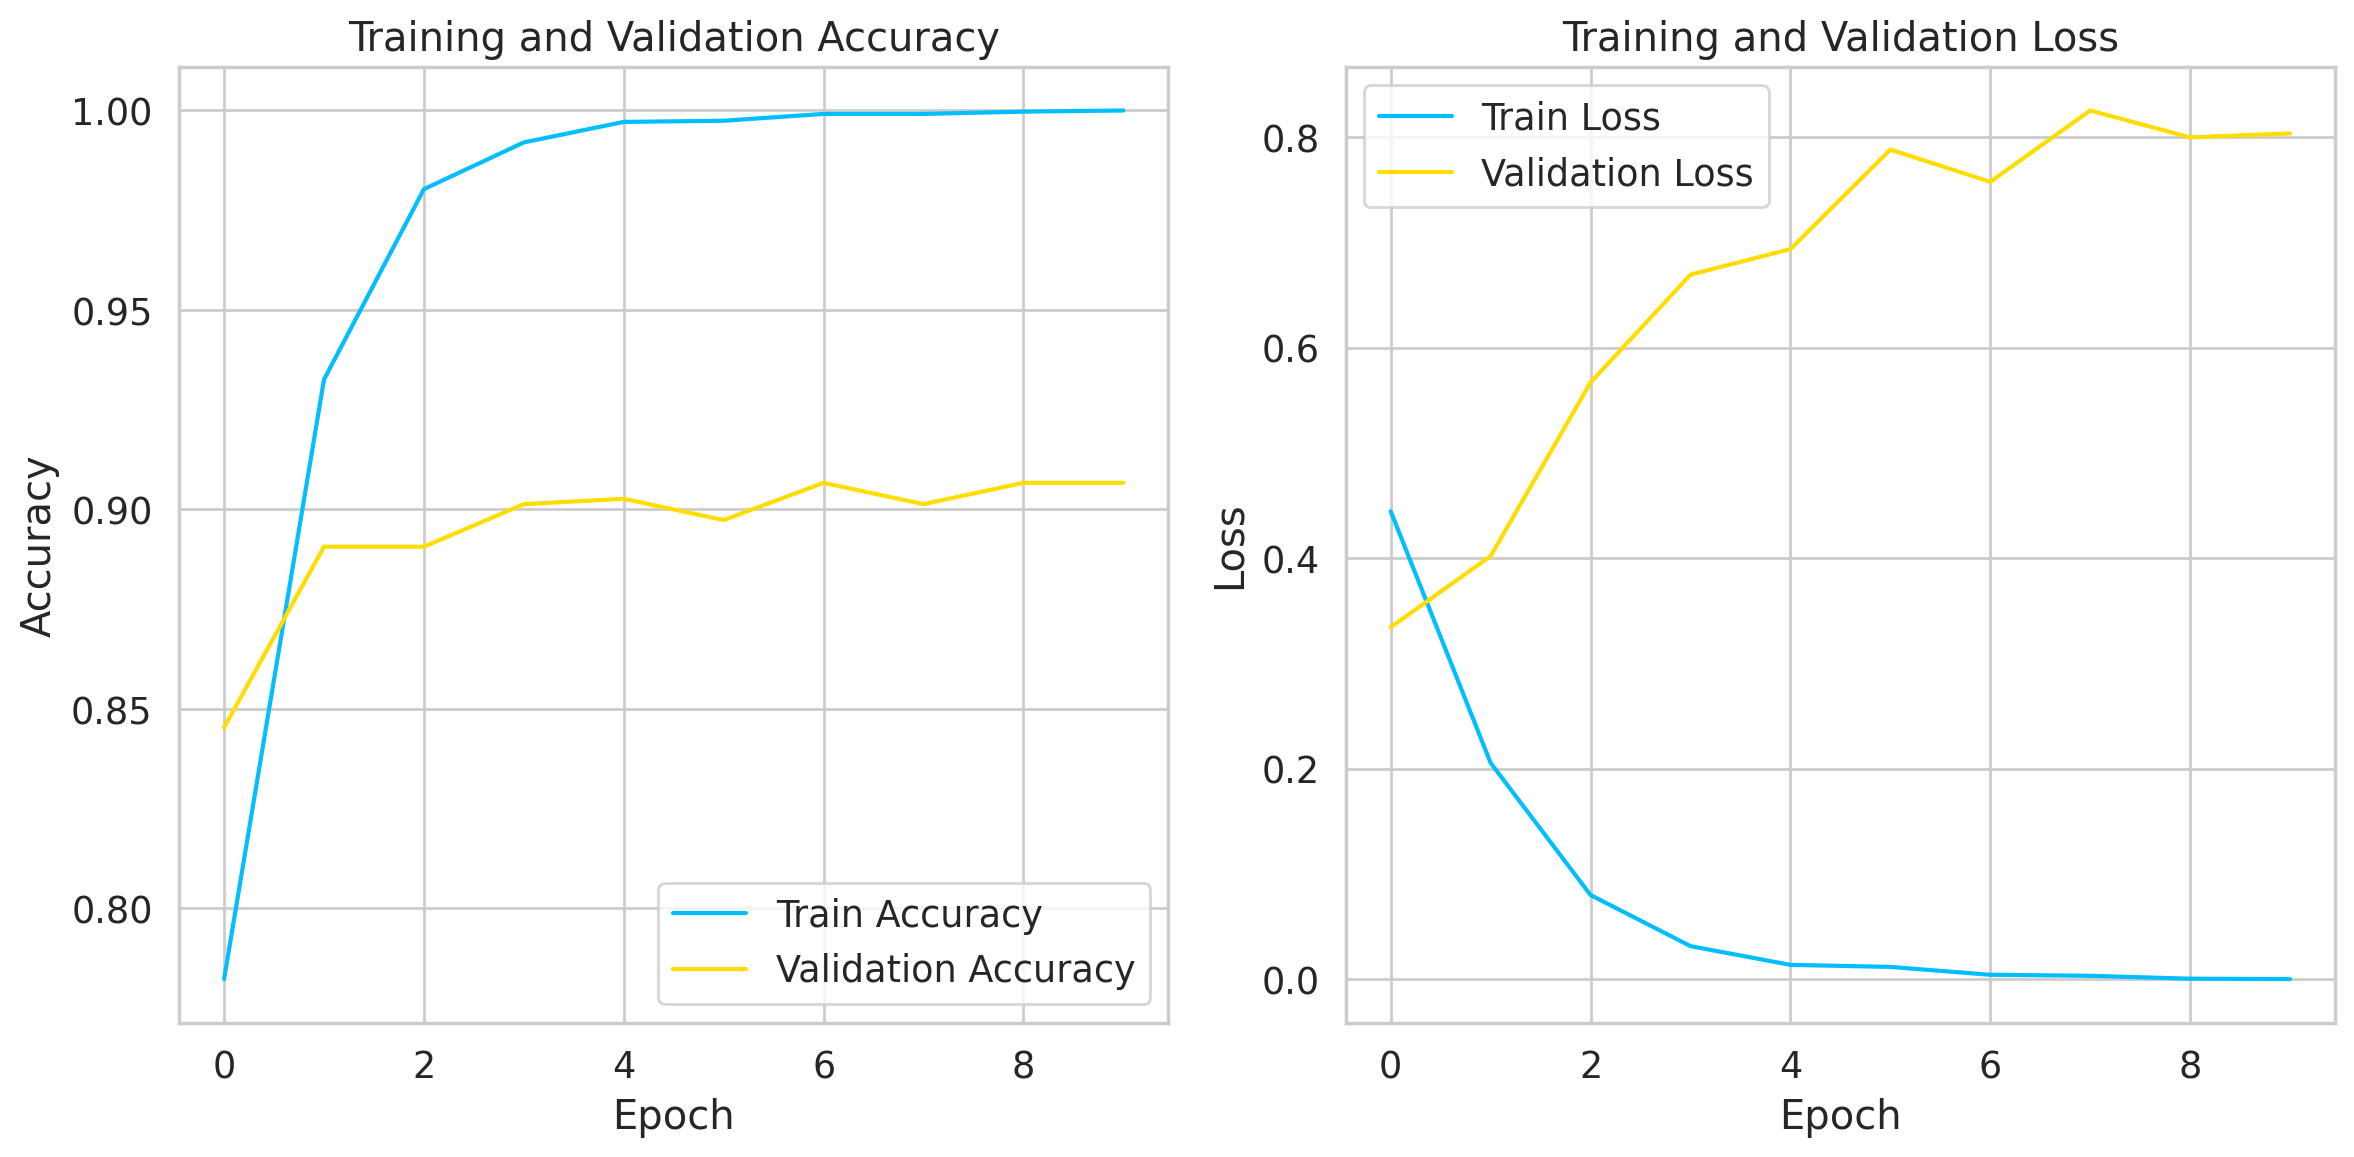

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Convert CUDA tensors to NumPy arrays
train_acc = [t.cpu().numpy() for t in history['train_acc']]
val_acc = [t.cpu().numpy() for t in history['val_acc']]
train_loss = history['train_loss']
val_loss = history['val_loss']

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

The training accuracy starts to approach 100% after 9 epochs. You can try to fine-tune the parameters a bit more.

##Evaluation

Let's calculate the accuracy on the test data.

In [47]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

0.8933333333333333

Our model seems to generalize well.

Let's look at the classification report

In [48]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [49]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.87      0.92      0.90       378
    positive       0.92      0.86      0.89       372

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750



Confusion Matrix

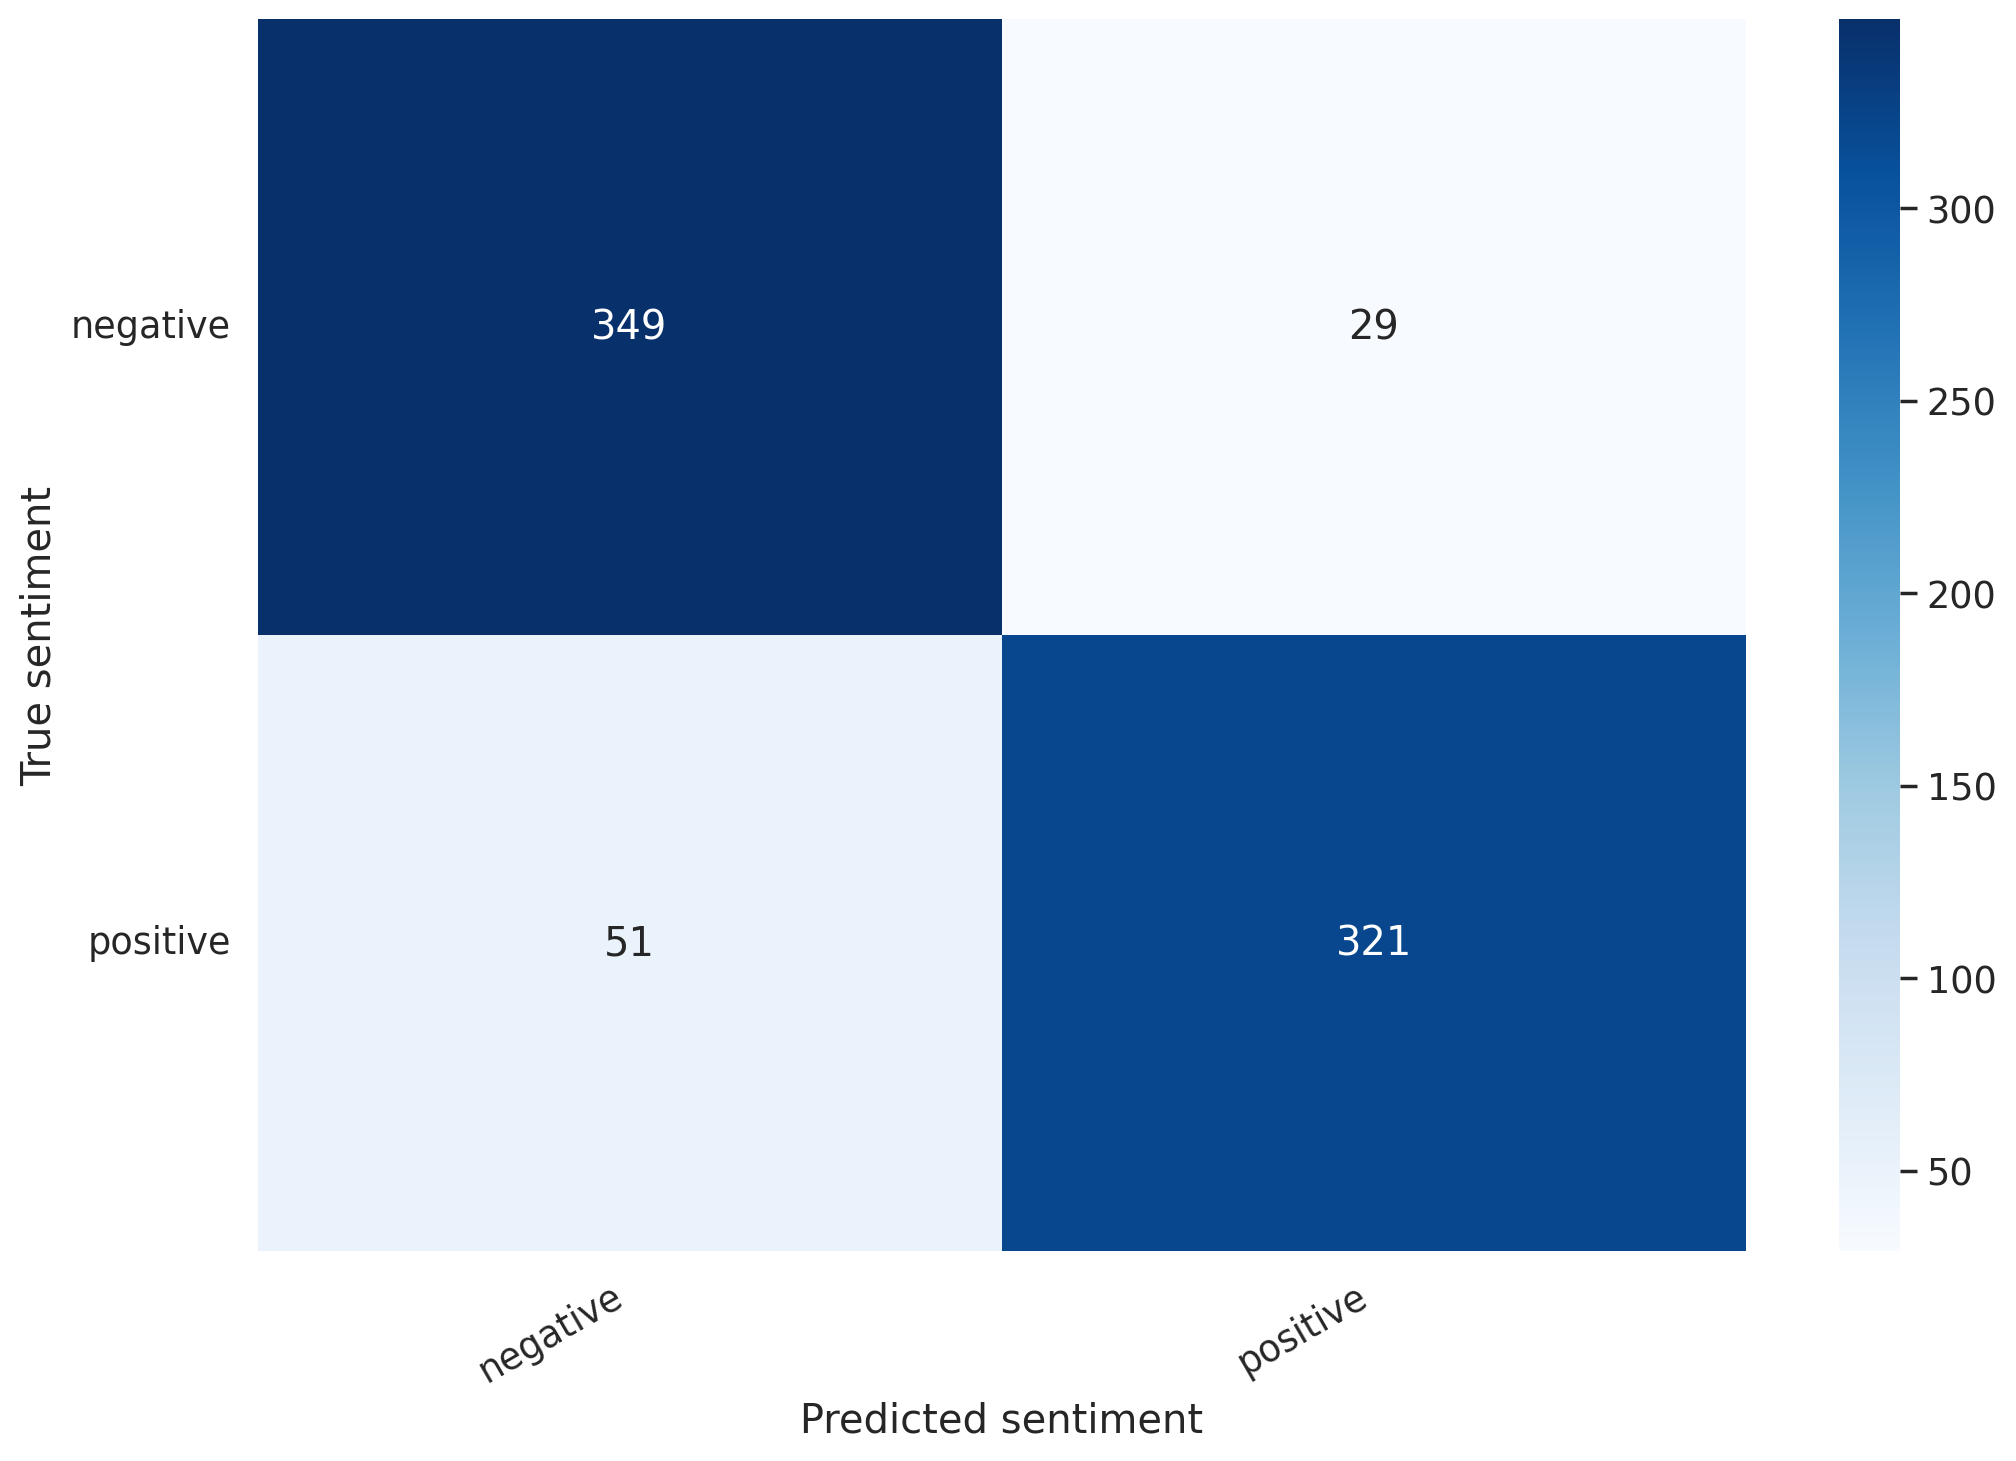

In [51]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This gives a good overview of the performance of our model.

Lets look at the example from the test data.

In [52]:
idx = 5

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [53]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

The directors cut version, which was the one I saw, was very long for
this type of movie. Almost two hours is way too long. If you have the
choice, definitely go for the non-directors cut.<br /><br />The main
plot is almost not taken up at all, the movie consists to the main
part of several murder scenes, which are connected but the feeling is
that they're only shown in order to fill the movie with splatterish
violence. The connection is not revealed until the latter part and the
lack of context bored me out long before I was there.<br /><br />As a
horror movie it doesn't work. You never get the required feel for the
characters due to mediocre acting and the general disposition
(character is presented, 15 minutes later character is dead). This
pictures strong side lies in the splatter part.

True sentiment: positive


Let's look at the confidence of each sentiment of our model

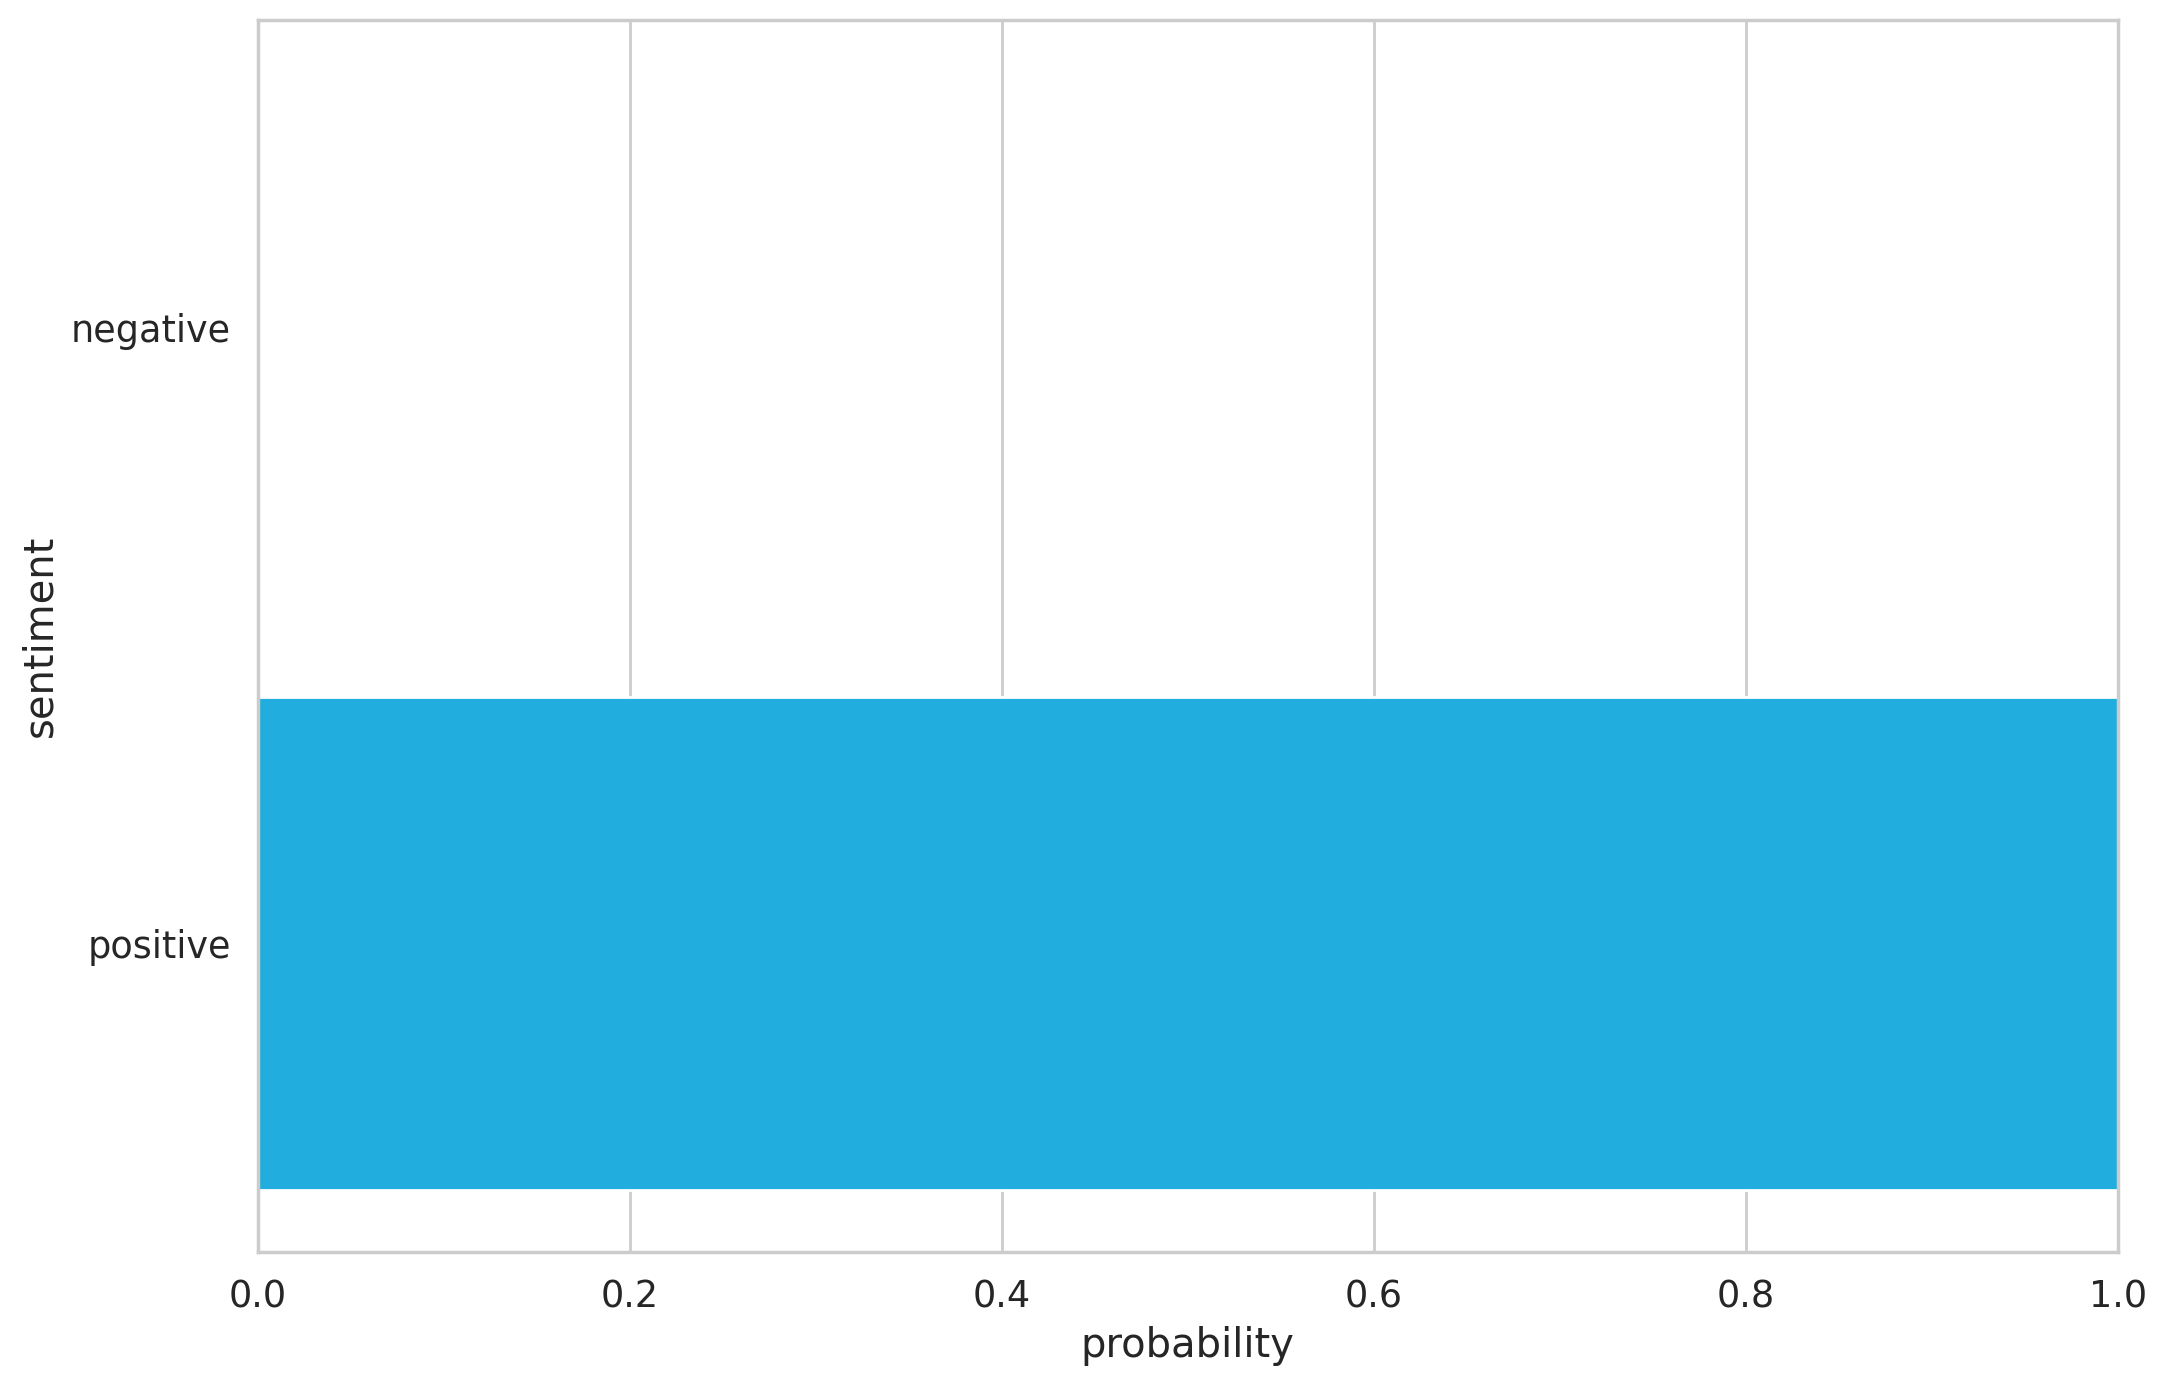

In [54]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);